# Preprocessing

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("Found GPU:", gpu)
else:
    print("No GPU detected")


Found GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import os

### Setting dataset and output directory

In [5]:
base_dir = "C:\/Users\khors\/Downloads\/DeepFake Face Recognition\/Datasets\/dfdc_train_part_00"

video_dataset = os.path.join(base_dir, "dfdc_train_part_0")

### Processing Metadata for Organizing

In [6]:
import json
metadata_filepath = os.path.join(video_dataset , "metadata.json")
with open(metadata_filepath, 'r') as file:
    metadata = json.load(file)

In [19]:
real_dir = os.path.join(base_dir, 'real')
fake_dir = os.path.join(base_dir, 'fake')

real_frames = os.path.join(real_dir, "real_frames")
fake_frames = os.path.join(fake_dir, "fake_frames")

real_faces = os.path.join(real_dir, "real_faces")
fake_faces = os.path.join(fake_dir, "fake_faces")

os.makedirs(real_dir, exist_ok=True)
os.makedirs(fake_dir, exist_ok=True)

os.makedirs(real_frames, exist_ok=True)
os.makedirs(fake_frames, exist_ok=True)

os.makedirs(real_faces, exist_ok=True)
os.makedirs(fake_faces, exist_ok=True)

In [20]:
real_videos = []
fake_videos = []
for videoInfo in metadata:
    if metadata[videoInfo]['label'] == "REAL":
        real_videos.append(videoInfo)
    else: 
        fake_videos.append(videoInfo)

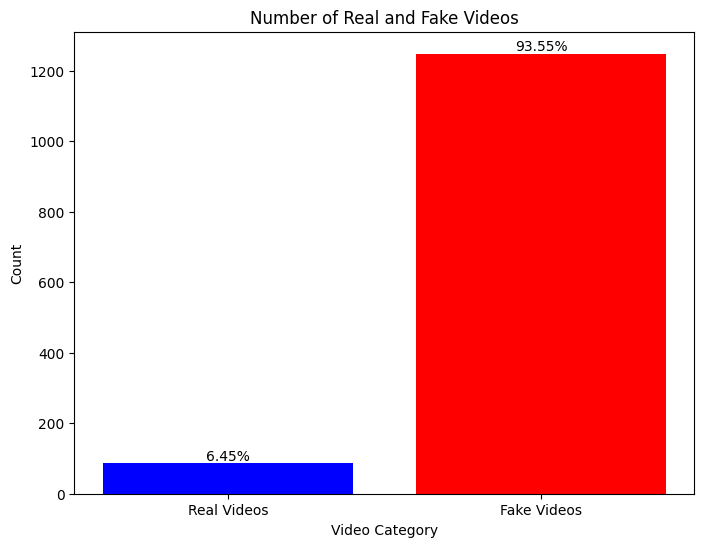

In [24]:
import matplotlib.pyplot as plt

# Data
categories = ['Real Videos', 'Fake Videos']
counts = [len(real_videos), len(fake_videos)]
total_videos = sum(counts)

# Calculate percentages
percentages = [count/total_videos * 100 for count in counts]

# Create bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, counts, color=['blue', 'red'])

# Add labels with percentages on top of bars
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.2f}%', ha='center', va='bottom')

# Add title and labels
plt.title('Number of Real and Fake Videos')
plt.xlabel('Video Category')
plt.ylabel('Count')

# Show plot
plt.show()

### Extracting frames

In [ ]:
def extract_frames(video_path, output_path, max_frames=None):
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Get frame count
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if max_frames is None:
        max_frames = frame_count
        
    # Extract video name from video path
    video_name = os.path.basename(video_path).split('.')[0]  # Extracting the name without extension
    
    # Loop through each frame
    for frame_number in range(max_frames):
        # Read the frame
        ret, frame = cap.read()
        if not ret:
            break
        
        # Save the frame as an image file
        frame_filename = f"{output_path}/frame_{video_name}_{frame_number:04d}.jpg"  # Adjust the filename format as needed
        cv2.imwrite(frame_filename, frame)
    
    # Release the video capture object
    cap.release()


In [ ]:
# max_frames = 100
video_count = 0
import tensorflow as tf

with tf.device('/GPU:0'):  # Specify GPU device
   for video_file in os.listdir(video_dataset):
    if video_file.endswith('.mp4'):  # Adjust the extension based on your dataset
        video_path = os.path.join(video_dataset, video_file)
        if video_file in real_videos:
            extract_frames(video_path, real_frames, 60)
        else:
            extract_frames(video_path, fake_frames, 5)
        
        video_count += 1
        print("Processing Video :", video_count)
            
    
   

### Face Detection

In [ ]:
# def detect_faces(input_path, output_path):

#     haar_cascade_filepath = '/Users/kiranm/Downloads/AIT-736/DeepFake Face Recognition/haarcascade_frontalface_default.xml'
#     face_cascade = cv2.CascadeClassifier(haar_cascade_filepath)

#     frame_counter = 0
#     for frame_file in os.listdir(input_path):
#         frame_counter += 1
#         print("Processing frame: ", frame_counter)
#         if frame_file.endswith('.jpg'):  # Adjust as needed
#             img = cv2.imread(os.path.join(input_path, frame_file))
#             gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#             faces = face_cascade.detectMultiScale(gray, 1.1, 4)

#             for (x, y, w, h) in faces:
#                 face = img[y:y+h, x:x+w]
#                 output_file_path = os.path.join(output_path, frame_file)
#                 cv2.imwrite(output_file_path, face)
#                 print("created")


In [ ]:
# detect_faces(real_frames, real_faces)
# detect_faces(fake_frames, fake_faces)

### MTCNN Face Detection

In [ ]:
pip install mtcnn

In [ ]:
from mtcnn import MTCNN

In [ ]:
detector = MTCNN()

In [ ]:
def detect_faces(frame_path, save_directory):
    # Load the image
    image = cv2.imread(frame_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect faces in the image
    detections = detector.detect_faces(image_rgb)

    # Ensure the save_directory exists
    os.makedirs(save_directory, exist_ok=True)

    # Process detections
    for i, detection in enumerate(detections):
        x, y, width, height = detection['box']
        # Ensure coordinates are positive
        x, y = max(0, x), max(0, y)
        # Crop the face from the image
        face = image[y:y+height, x:x+width]

        # Construct a filename for the cropped face
        frame_basename = os.path.basename(frame_path)
        save_path = os.path.join(save_directory, f"face_{i}_{frame_basename}")

        # Save the cropped face
        cv2.imwrite(save_path, face)


In [ ]:
import time

import tensorflow as tf

with tf.device('/GPU:0'):  
    def process_directory(directory, save_directory):
        frame_count=0
        for frame_name in os.listdir(directory):
            frame_path = os.path.join(directory, frame_name)
            frame_count+=1
            print("\rProcessing frame", frame_count)
            detect_faces(frame_path, save_directory)
    
    start_time = time.time()
    # Process 'real' frames
    print("Processing real frames...")
    process_directory(real_frames, real_faces)
    
    
    # Process 'fake' frames
    print("Processing fake frames...")
    process_directory(fake_frames, fake_faces)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print("Elapsed time:", elapsed_time, "seconds")

